In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-06-22 13:26:22.608929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(912, 57)


,ModelID,0,1,2,3,4,5,6,7,8,...,46,47,48,49,50,51,52,53,54,55
0,ACH-001820,0.033012,2.454029,-0.200020,-0.930952,-0.105004,0.066286,0.656221,-0.513948,2.329023,...,-1.201740,1.520554,1.236150,0.914869,-0.434785,1.888903,1.786871,-0.593740,2.349837,1.024181
1,ACH-000632,1.335897,1.458422,-0.402413,-0.666326,1.150006,0.578801,-0.016531,1.435949,-0.926741,...,0.760013,0.551972,-0.731740,-1.325295,0.648749,-0.337791,2.334729,0.019244,-0.128537,0.805020
2,ACH-000403,0.285806,1.196845,2.347686,1.470275,1.040130,0.043655,0.606085,2.100534,1.584386,...,1.336702,0.405433,-0.276691,2.301311,0.185295,0.255464,0.933351,4.069458,0.387041,0.155446
3,ACH-002233,0.129747,1.317303,0.584817,0.780637,-0.552675,-1.319666,2.078983,-1.364332,0.892158,...,-0.315825,0.561363,0.062464,1.544612,1.967639,2.207677,3.532746,0.508986,2.050455,-0.261173
4,ACH-001852,0.374337,0.349337,-0.473771,0.542943,-0.099260,-1.154139,1.227572,0.580085,2.088321,...,-0.342426,0.238972,1.536716,0.699604,-1.039683,-0.179338,1.853832,0.490723,0.999574,1.191672


In [8]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001820,Adult,Female,train
1,ACH-000632,Adult,Male,train
2,ACH-000403,Adult,Male,train
3,ACH-002233,Adult,Female,train
4,ACH-001852,Adult,Male,train
...,...,...,...,...
907,ACH-000900,Adult,Male,test
908,ACH-001129,Adult,Male,test
909,ACH-000665,Adult,Male,test
910,ACH-000405,Adult,Male,test


In [9]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_or_test")

/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


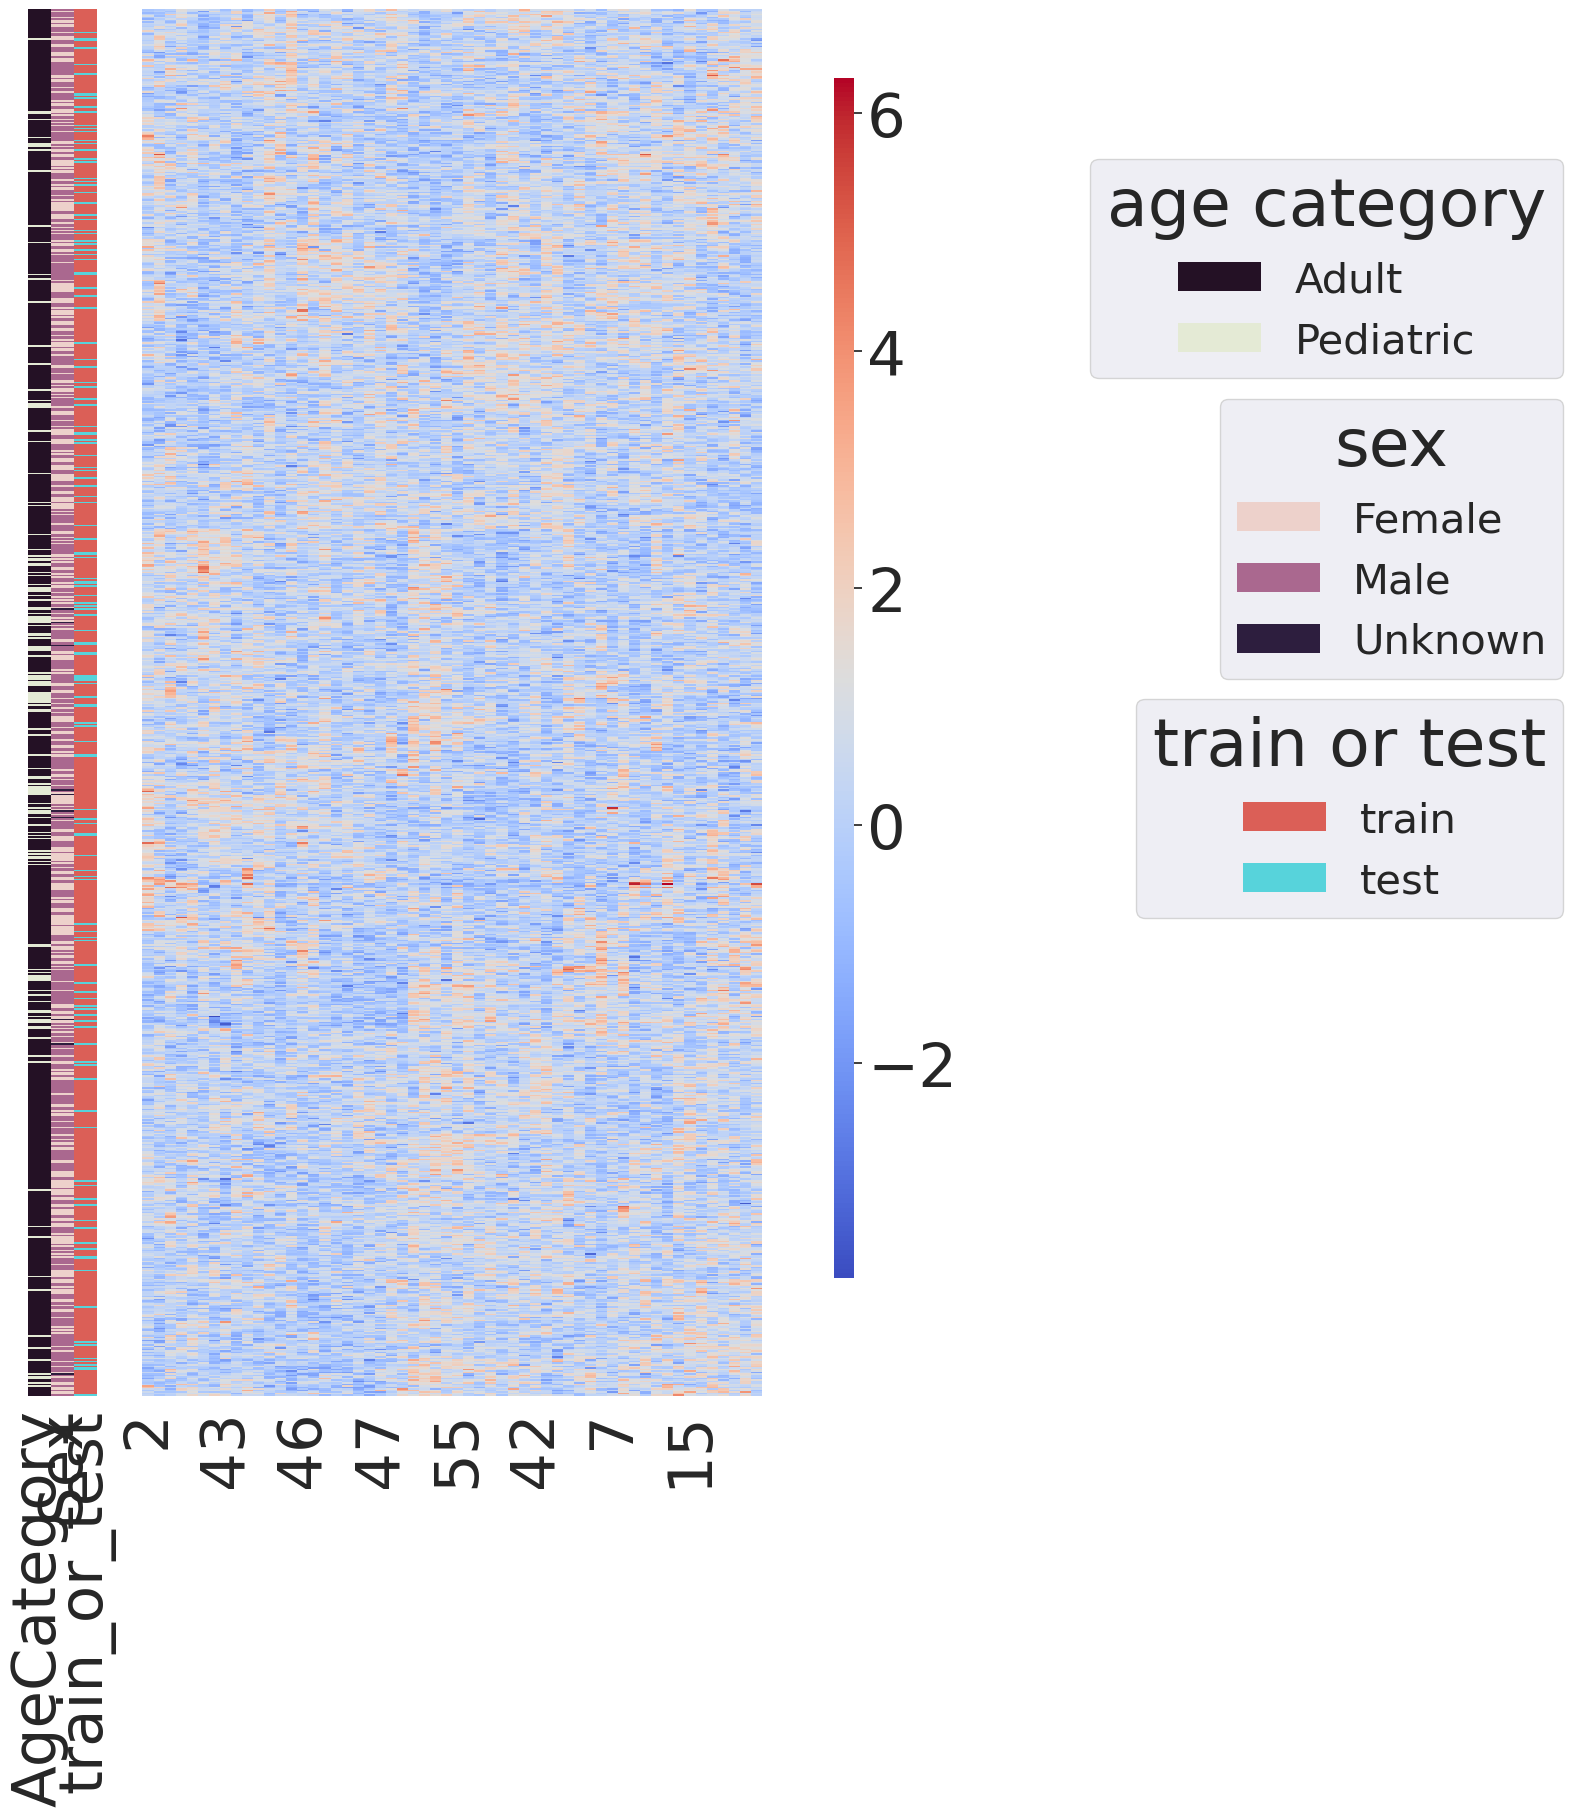

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train or test",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.003621,-0.030539,0.005803,-0.053523,0.081258,-0.061141,0.009467,0.041177,0.024255,-0.051101,...,-0.007620,0.076311,0.004459,0.019866,0.018265,-0.008330,-0.084591,0.024035,-0.018626,-0.028110
1,-0.035204,0.054120,-0.016583,0.031840,0.053772,0.043985,-0.038978,-0.041584,-0.049981,-0.060264,...,-0.047986,0.009264,0.037031,-0.020135,-0.069784,-0.042692,0.044006,-0.066479,-0.041929,-0.131357
2,-0.008716,0.055790,-0.016234,0.026713,-0.026491,-0.031592,-0.039716,-0.002119,-0.030370,-0.003438,...,-0.037923,-0.049077,0.005198,-0.036426,-0.009239,-0.044510,-0.032881,-0.018756,-0.040605,-0.014352
3,-0.043036,-0.002256,-0.010101,-0.002127,-0.058436,-0.019942,0.002100,-0.025927,0.040344,0.002491,...,-0.012966,0.009157,-0.002929,-0.037093,0.019743,-0.057616,-0.114067,-0.041586,0.000354,-0.008621
4,-0.044866,0.018422,-0.017908,-0.000651,-0.004964,-0.053290,-0.014199,0.063176,-0.040644,0.106292,...,-0.000491,-0.096097,-0.030075,-0.004071,-0.036055,0.027727,0.022332,-0.125409,-0.000867,-0.022037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,0.029361,-0.037998,-0.007593,-0.047059,-0.077787,0.034963,-0.020533,0.067814,0.029491,-0.067224,...,-0.018121,-0.004097,0.013766,-0.056247,0.057211,-0.023603,-0.084436,0.044422,-0.029090,-0.032790
2858,-0.006972,-0.071475,-0.009690,-0.017608,-0.068422,-0.100746,0.018833,-0.066054,0.046943,-0.032885,...,-0.087620,-0.026344,0.052524,-0.066461,-0.022018,0.018828,0.024428,-0.082267,-0.006888,0.076227
2859,0.038006,-0.083023,0.066593,-0.075161,-0.034186,0.002092,-0.000324,0.028184,0.027588,-0.084728,...,-0.051138,0.021859,0.062528,0.026095,0.001055,0.055617,-0.073788,0.055768,-0.020421,-0.013199
2860,-0.043035,-0.046510,-0.048597,-0.066711,-0.087669,-0.081308,-0.025280,-0.033959,-0.039828,-0.063361,...,-0.045572,-0.055726,0.058177,0.008623,0.049985,-0.026777,-0.025927,0.001791,-0.086756,-0.015903


/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


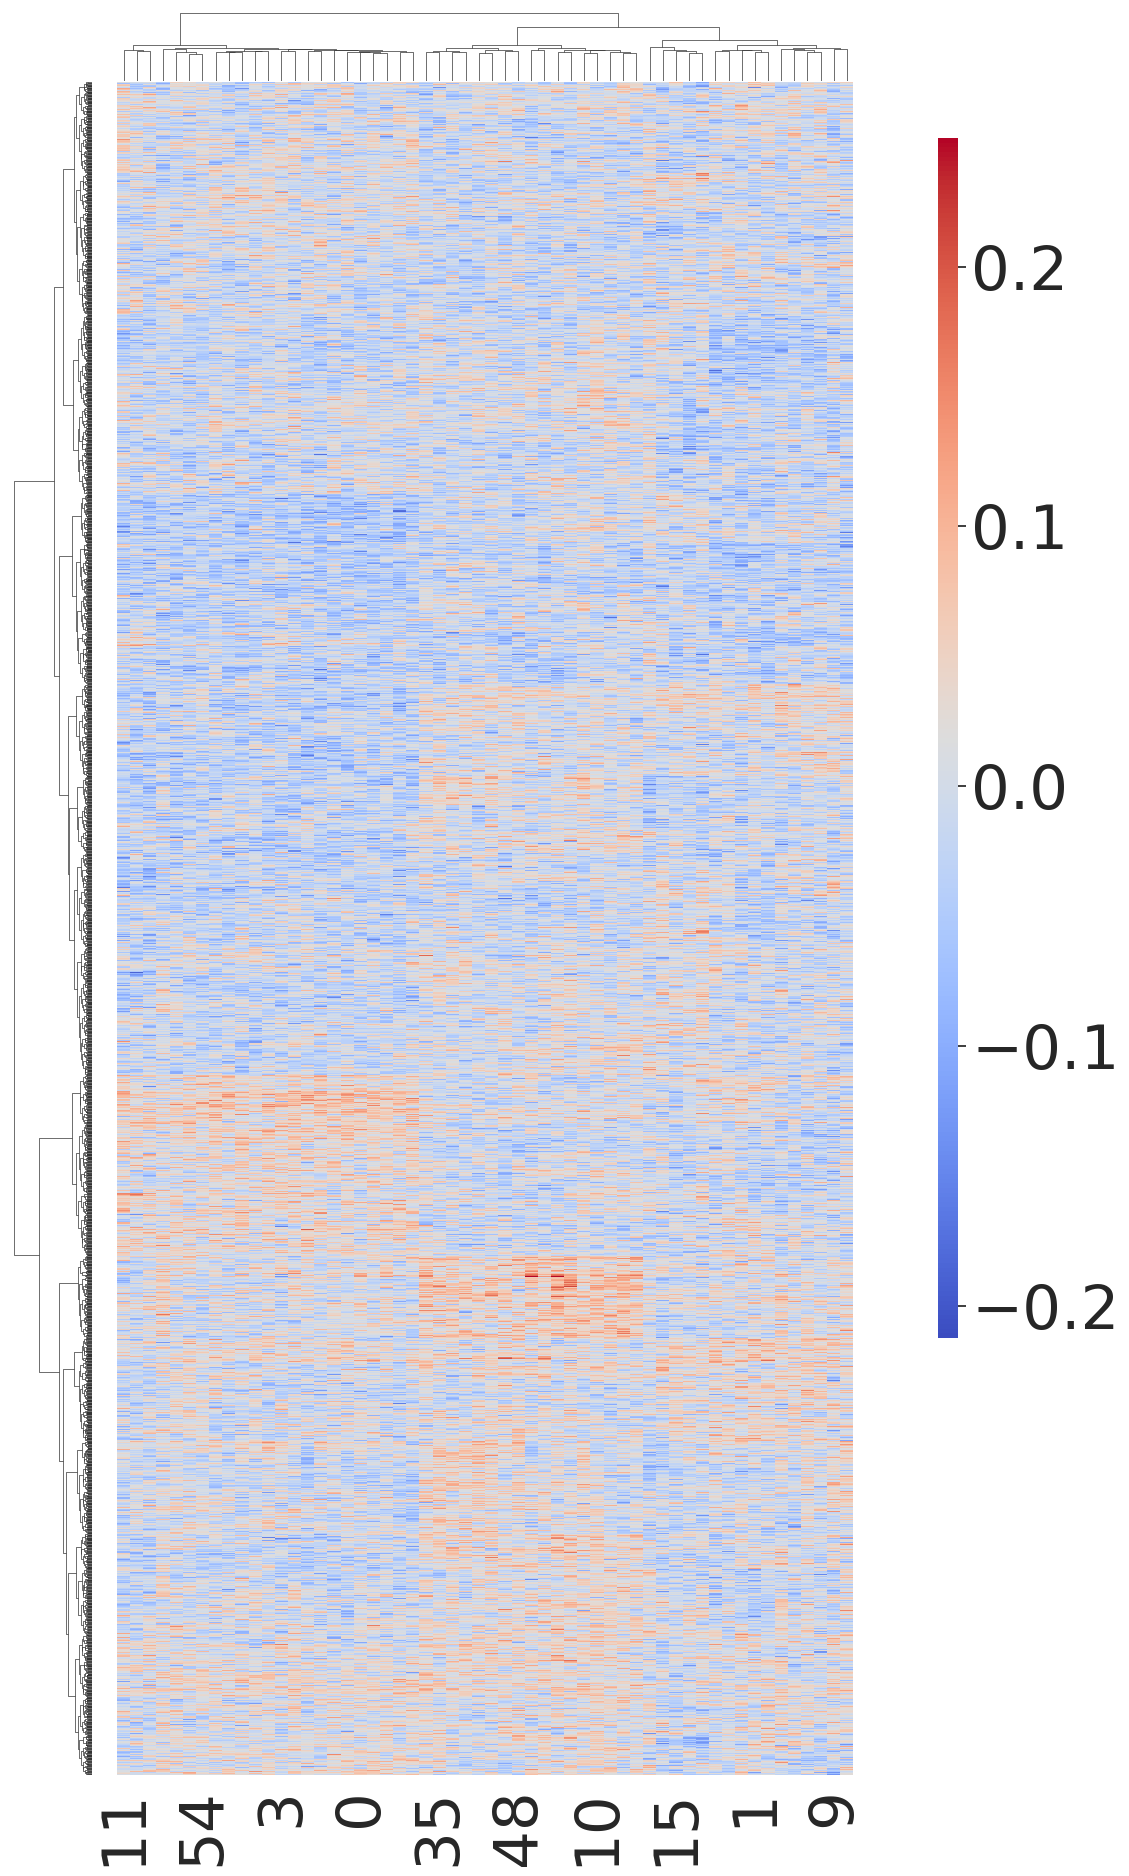

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
